# LSTM

In [1]:
#import packages
import numpy as np
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime
import pickle
import pandas as pd
%matplotlib inline

#predefined activation function and its derivative
def Sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def dSigmoid(values): 
    return values*(1-values)

def Tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def dtanh(values): 
    return 1. - values**2

def rand_arr(a, b, *args): 
    seed(0)
    return rand(*args)*(b - a) + a

#LSTM Class
class LSTM:
    def __init__(self, X_dim, y_dim, neuron):
        
        self.X_dim = X_dim 
        self.y_dim = y_dim
        self.neuron = neuron
        
        #initiate weight
        self.weight_f = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_i = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_g = rand_arr(-0.1, 0.1, neuron, X_dim + neuron) 
        self.weight_o = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_out = rand_arr(-0.1, 0.1, y_dim, neuron)
        
        #initiate bias
        self.bias_f = rand_arr(-0.1, 0.1, neuron) 
        self.bias_i = rand_arr(-0.1, 0.1, neuron) 
        self.bias_g = rand_arr(-0.1, 0.1, neuron) 
        self.bias_o = rand_arr(-0.1, 0.1, neuron)
        self.bias_out = rand_arr(-0.1, 0.1, y_dim)
    
    def forward(self, inputs, outputs):
        X = inputs
        y = outputs
        
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        #show error
        #print(np.array(self.error).mean())
    
    def backward(self, inputs, outputs):
        self.diff_out = []
        self.diff_h = []
        self.diff_h_bottom = [zeros(self.neuron)]
        self.diff_s_up = [zeros(self.neuron)]
        self.diff_s = []
        self.diff_o = []
        self.diff_g = []
        self.diff_i = []
        self.diff_f = []
        for i in range(len(inputs)-1,-1,-1):
            #derivate of output
            if i == len(inputs)-1:
                self.diff_out  = [2*(self.out[i] - outputs[i])] + self.diff_out
                self.diff_h = [self.diff_out[0]*dSigmoid(self.weight_out@self.h[i+1] + self.bias_out)*self.weight_out + self.diff_h_bottom[0]] + self.diff_h
            else:
                self.diff_h = [self.diff_h_bottom[0]] + self.diff_h
            
            
            #derivative of gate/neural network operation
            self.diff_s = [self.diff_h[0]*self.o[i]*dtanh(self.s[i+1]) + self.diff_s_up[0]] + self.diff_s
            self.diff_o = [self.diff_h[0]*Tanh(self.s[i+1])] + self.diff_o
            self.diff_g = [self.i[i]*self.diff_s[0]] + self.diff_g
            self.diff_i = [self.g[i]*self.diff_s[0]] + self.diff_i
            self.diff_f = [self.s[i]*self.diff_s[0]] + self.diff_f
            
            #derivative of concatenation of input dan previous output value
            self.dX_concat = (self.diff_o[0].T*(dSigmoid(self.o[i]).reshape(self.neuron,1))).T@self.weight_o
            self.dX_concat += (self.diff_g[0].T*(dSigmoid(self.g[i]).reshape(self.neuron,1))).T@self.weight_g
            self.dX_concat += (self.diff_i[0].T*(dSigmoid(self.i[i]).reshape(self.neuron,1))).T@self.weight_i
            self.dX_concat += (self.diff_f[0].T*(dSigmoid(self.f[i]).reshape(self.neuron,1))).T@self.weight_f
            
            #update value of long and short term memory
            self.diff_h_bottom = [self.dX_concat[-1][self.X_dim:]] + self.diff_h_bottom
            self.diff_s_up = [self.diff_s[0]*self.f[i]] + self.diff_s_up
            
    def update(self, alpha):
        
        #alpha 
        
        #update everyweight and bias
        self.weight_out -= alpha*self.diff_out[0].reshape(1,1)@self.h[1].T.reshape(1,self.neuron)
        self.bias_out -= alpha*self.diff_out[0]
        
        self.weight_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).reshape(self.neuron,)
        
        self.weight_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).reshape(self.neuron,)
        
        self.weight_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).reshape(self.neuron,)
        
        self.weight_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).T.reshape(self.neuron,1)@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).reshape(self.neuron,)
    
    def predict(self, inputs, outputs):
        X = inputs
        y = outputs
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        
        return [self.out[-1][0],self.y[-1]]
    
    def show_progress(self):
        return abs(self.y[-1][0] - self.out[-1])

# Import Dataset

In [2]:
df = pd.read_csv('Datasets/FISH-long.csv')
df.drop('Volume', inplace=True, axis=1)
df

,Date,Open,High,Low,Close,Adj Close
0,2017-01-02,4000.0,4000.0,4000.0,4000.0,3481.111816
1,2017-01-03,3900.0,5000.0,3900.0,4800.0,4177.333984
2,2017-01-04,4800.0,4800.0,4800.0,4800.0,4177.333984
3,2017-01-05,4800.0,4800.0,4800.0,4800.0,4177.333984
4,2017-01-06,4800.0,4800.0,4800.0,4800.0,4177.333984
...,...,...,...,...,...,...
1257,2021-12-24,7400.0,7400.0,7400.0,7400.0,7400.000000
1258,2021-12-27,7650.0,7650.0,7650.0,7650.0,7650.000000
1259,2021-12-28,7650.0,7650.0,7650.0,7650.0,7650.000000
1260,2021-12-29,7650.0,7650.0,7650.0,7650.0,7650.000000


In [3]:
df.describe()

,Open,High,Low,Close,Adj Close
count,1261.000000,1261.000000,1261.000000,1261.000000,1261.000000
mean,3500.967486,3536.534496,3481.205393,3513.517050,3279.232684
std,1660.679286,1718.748346,1643.214105,1679.724828,1730.648108
min,1760.000000,1760.000000,1500.000000,1760.000000,1559.867432
25%,2620.000000,2660.000000,2620.000000,2620.000000,2481.607178
50%,3000.000000,3000.000000,3000.000000,3000.000000,2735.588379
75%,3680.000000,3690.000000,3680.000000,3680.000000,3429.117676
max,14150.000000,16850.000000,13075.000000,14050.000000,14050.000000


In [4]:
df_open = df.reset_index()['Open']
df_open

0       4000.0
1       3900.0
2       4800.0
3       4800.0
4       4800.0
         ...  
1257    7400.0
1258    7650.0
1259    7650.0
1260    7650.0
1261    7650.0
Name: Open, Length: 1262, dtype: float64

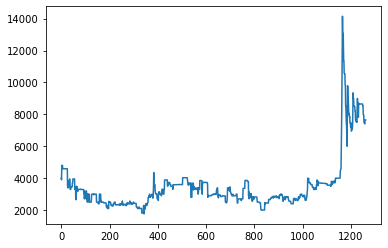

In [5]:
plt.plot(df_open)

# MinMax Scaler

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df_open = scaler.fit_transform(np.array(df_open).reshape(-1,1))
df_open

array([[0.18079096],
       [0.17271994],
       [0.24535916],
       ...,
       [0.47538337],
       [0.47538337],
       [0.47538337]])

# Splitting Training and Testing

In [7]:
training_size = int(len(df_open)*0.8)
test_size = len(df_open)-training_size
train_data, test_data = df_open[0:training_size,:], df_open[training_size:len(df_open),:1]

In [8]:
training_size, test_size

(1009, 253)

In [9]:
xs = train_data

In [10]:
#Standarized the dataset
N       = xs.shape[0]

#hypreparameter
nc      = 4  
Ts      = 5
x_dim   = 10
alpha   = 0.01
epochs  = 500

xt      = xs[0:N-x_dim,:]

for i in range(x_dim):
    xt  = hstack((xt, xs[i+1:N-x_dim+i+1]))   

X_train = xt[:-30, 0:x_dim]     
y_train = xt[:-30, x_dim:x_dim+1]  
X_test = xt[-30:, 0:x_dim]     
y_test = xt[-30:, x_dim:x_dim+1]  

In [ ]:
me = LSTM(x_dim,1,nc)
for i in range(1000):
    print('-------------',i+1,'-------------')
    for j in range(X_train.shape[0]-Ts):
        me.forward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.backward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.update(alpha)
    hehe = []
    for j in range(X_test.shape[0]-Ts):
        me.forward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.backward(X_test[j:j+Ts],y_test[j:j+Ts])
        hehe.append(me.show_progress())    
    print(np.array(hehe).mean())

------------- 1 -------------
nan
------------- 2 -------------
nan
------------- 3 -------------
nan
------------- 4 -------------
nan
------------- 5 -------------
nan
------------- 6 -------------
nan
------------- 7 -------------
nan
------------- 8 -------------
nan
------------- 9 -------------
nan
------------- 10 -------------
nan
------------- 11 -------------
nan
------------- 12 -------------
nan
------------- 13 -------------
nan
------------- 14 -------------
nan
------------- 15 -------------
nan
------------- 16 -------------
nan
------------- 17 -------------
nan
------------- 18 -------------
nan
------------- 19 -------------
nan
------------- 20 -------------
nan
------------- 21 -------------
nan
------------- 22 -------------
nan
------------- 23 -------------
nan
------------- 24 -------------
nan
------------- 25 -------------
nan
------------- 26 -------------
nan
------------- 27 -------------
nan
------------- 28 -------------
nan
------------- 29 ------------

nan
------------- 232 -------------
nan
------------- 233 -------------
nan
------------- 234 -------------
nan
------------- 235 -------------
nan
------------- 236 -------------
nan
------------- 237 -------------
nan
------------- 238 -------------
nan
------------- 239 -------------
nan
------------- 240 -------------
nan
------------- 241 -------------
nan
------------- 242 -------------
nan
------------- 243 -------------
nan
------------- 244 -------------
nan
------------- 245 -------------
nan
------------- 246 -------------
nan
------------- 247 -------------
nan
------------- 248 -------------
nan
------------- 249 -------------
nan
------------- 250 -------------
nan
------------- 251 -------------
nan
------------- 252 -------------
nan
------------- 253 -------------
nan
------------- 254 -------------
nan
------------- 255 -------------
nan
------------- 256 -------------
nan
------------- 257 -------------
nan
------------- 258 -------------
nan
------------- 259 ------

/var/folders/lv/j9w__j_11b1cntk8h5tlnkvr0000gn/T/ipykernel_6163/1945362580.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(out)[:,0],label = 'pred')
/var/folders/lv/j9w__j_11b1cntk8h5tlnkvr0000gn/T/ipykernel_6163/1945362580.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(out)[:,1],label = 'real')


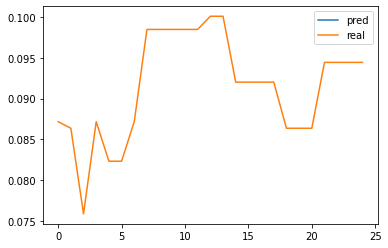

In [12]:
import matplotlib.pyplot as plt

out = []
for j in range(X_test.shape[0]-Ts):
    out.append(me.predict(X_test[j:j+Ts],y_test[j:j+Ts]))

plt.plot(np.array(out)[:,0],label = 'pred')
plt.plot(np.array(out)[:,1],label = 'real')
plt.legend()